<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw3/Homework3_autoregressive_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 180 (delta 78), reused 133 (delta 49), pack-reused 0
Receiving objects: 100% (180/180), 28.64 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=45c91c1576e1a5d8a06aea2facd4c43918c7823df3393de0f0411541d9119c4c
  Stored in directory: /private/var/folders/zg/dd_4mghs167bb5hrrgz9w4y40000gn/T/pip-ephem-w

In [8]:
from dul_2021.utils.hw3_utils import *


# Question 1: Autoregressive Flows for Images

Adapt your PixelCNN implementation from Homework 2 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 2 1(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


In [35]:
from abc import ABC, abstractmethod
import math

from scipy.optimize import bisect

import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch import Tensor, nn
from torch.nn import functional as F, utils
from torch.distributions import Normal, Uniform
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm

from dul_2021.utils.hw2_utils import *

In [77]:
@torch.no_grad()
def test_epoch(model, dl):
    loss = 0.
    for batch in tqdm(dl, leave=False, desc='Testing'):
        batch = batch.float().to(DEVICE)
        loss -= model.log_prob(batch).mean()
    
    return (loss / len(dl)).item()


def train_epoch(model, optimizer, dl, loss_acc):
    bar = tqdm(dl, leave=False, desc='Training')
    for batch in bar:
        batch = batch.float().to(DEVICE)
        
        loss = -model.log_prob(0.5 * (batch + torch.rand_like(batch))).mean()
        bar.set_postfix_str(f'loss = {loss.item():.5f}')
        loss_acc.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        utils.clip_grad_norm_(model.parameters(), 2.)
        optimizer.step()


def train(model, optimizer, train_dl, test_dl, epochs=10):
    train_losses = []
    test_losses = [test_epoch(model, test_dl)]
    
    range_bar = tqdm(range(epochs), desc='Epoch')
    for ep in range_bar:
        train_epoch(model, optimizer, train_dl, train_losses)
        
        loss = test_epoch(model, test_dl)
        test_losses.append(loss)
        range_bar.set_postfix_str(f'test_loss = {loss:.5f}')
        
    return train_losses, test_losses


@torch.no_grad()
def pixel_inverse_flow(base_dist, w, mu, log_sigma, n_components):
    b = w.size(0)
    pixels = w.new_zeros(b)
    z = base_dist.sample((b, ))
    
    for i in range(b):
        dist = Normal(mu[i], log_sigma[i].exp())
        def _f(x):
            x = w.new_tensor(np.repeat(x, n_components))
            return w[i].dot(dist.cdf(x)) - z[i]
        
        pixels[i] = bisect(_f, -20, 20)
        
    return pixels
        

@torch.no_grad()
def sample(model, input_shape, n=100, cond=None):
    h, w, c = input_shape
    x = torch.zeros(n, c, h, w, device=DEVICE)
    
    with tqdm(total=np.prod(input_shape), desc='Sampling') as bar:
        for h_ in range(input_shape[0]):
            for w_ in range(input_shape[1]):
                for c_ in range(input_shape[2]):
                    w, mu, log_sigma = model(x)
                    w, mu, log_sigma = w[:, :, c_, h_, w_], mu[:, :, c_, h_, w_], log_sigma[:, :, c_, h_, w_]
                    x[:, c_, h_, w_] = pixel_inverse_flow(
                        model.base_dist, w.softmax(1), mu, log_sigma, model.n_components
                    )
                    bar.update(1)
    x = x.permute(0, 2, 3, 1)
    return x.clamp(0., 1.).cpu().numpy()

In [78]:
class MaskedConv2d(nn.Conv2d, ABC):
    def __init__(self, in_channels, out_channels, kernel_size, *args, color_cond=False, cond_size=None, **kwargs):
        self.color_cond = color_cond
        super().__init__(in_channels, out_channels, kernel_size, *args, **kwargs)
        self.register_buffer('mask', self.get_mask())
        
        if cond_size is not None:
            self.cond_encoder = nn.Embedding(cond_size, out_channels)
        else:
            self.register_parameter('cond_encoder', None)
       
    @abstractmethod
    def get_mask(self) -> Tensor:
        raise NotImplementedError
        
    def forward(self, x, cond=None):
        x = F.conv2d(x, self.weight * self.mask, self.bias, self.stride, self.padding, self.dilation, self.groups)
        
        if self.cond_encoder is not None:
            x = x + self.cond_encoder(cond)[..., None, None]
            
        return x
    

class Conv2dA(MaskedConv2d):
    def get_mask(self):
        oc, ic, h, w = self.weight.size()
        mask = torch.zeros(oc, ic, h, w)
        mask[..., :h // 2, :] = 1.
        mask[..., h // 2, :w // 2] = 1.
        
        if self.color_cond:
            one_third_out, one_third_in = oc // 3, ic // 3
            mask[one_third_out:2 * one_third_out, :one_third_in, h // 2, w // 2] = 1.
            mask[2 * one_third_out:, :2 * one_third_in, h // 2, w // 2] = 1.
        return mask
        
        
class Conv2dB(MaskedConv2d):
    def get_mask(self):
        oc, ic, h, w = self.weight.size()
        mask = torch.zeros(oc, ic, h, w)
        mask[..., :h // 2, :] = 1.
        mask[..., h // 2, :w // 2] = 1.
        
        if self.color_cond:
            one_third_out, one_third_in = oc // 3, ic // 3
            mask[:one_third_out, :one_third_in, h // 2, w // 2] = 1.
            mask[one_third_out:2 * one_third_out, :2 * one_third_in, h // 2, w // 2] = 1.
            mask[2 * one_third_out:, :, h // 2, w // 2] = 1.
        else:
            mask[..., h // 2, w // 2] = 1
        return mask
    

class ResBlock(nn.Module):
    def __init__(self, channels, kernel_size=7, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ReLU(inplace=True),
            Conv2dB(channels, channels // 2, 1, **kwargs),
            nn.ReLU(inplace=True),
            Conv2dB(channels // 2, channels // 2, kernel_size, padding=kernel_size // 2, **kwargs),
            nn.ReLU(inplace=True),
            Conv2dB(channels // 2, channels, 1, **kwargs),
        ])
        
    def forward(self, x, cond=None):
        out = x
        for i, layer in enumerate(self.layers):
            if i % 2 != 0:
                out = layer(out, cond)
            else:
                out = layer(out)
        return x + out
    
    
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters, *args, color_cond, **kwargs):
        if color_cond:
            n_filters //= 3
        super().__init__(n_filters, *args, **kwargs)
        self.color_cond = color_cond

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_size = x.size()
        
        if self.color_cond:
            x = x.view((*x.size()[:-1], 3, -1))
            
        x = super().forward(x)
        
        if self.color_cond:
            x = x.view(x_size)
            
        return x.permute(0, 3, 1, 2).contiguous()
    
    
    
class PixelCNN(nn.Module):
    def __init__(self, n_colors, n_color_values, n_channels, 
                 n_layers=5, kernel_size=7, color_cond=False, cond_size=None):
        super().__init__()
        self.n_colors = n_colors
        self.n_color_values = n_color_values
        self.color_cond = color_cond
        
        cond_kws = {'color_cond': color_cond, 'cond_size': cond_size}
        self.layers = nn.ModuleList(
            [Conv2dA(n_colors, n_channels, kernel_size, padding=kernel_size // 2, **cond_kws)]
        )
        
        for i in range(n_layers):
            self.layers.append(LayerNorm(n_channels, color_cond=color_cond))
            self.layers.append(ResBlock(n_channels, kernel_size=kernel_size, **cond_kws))
        
        self.layers.append(LayerNorm(n_channels, color_cond=color_cond))
        self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(Conv2dB(n_channels, n_colors * n_color_values, 1, **cond_kws))
        
    def forward(self, x, cond=None):
        c, h, w = x.size()[1:]
        x = x.float() / self.n_color_values
        for layer in self.layers:
            if isinstance(layer, (MaskedConv2d, ResBlock)):
                x = layer(x, cond)
            else:
                x = layer(x)
        
        if self.color_cond:
            x = x.view(-1, self.n_colors, self.n_color_values, h, w).permute(0, 2, 1, 3, 4)
        else:
            x = x.view(-1, self.n_color_values, c, h, w)
        return x
    
    
class AutoregressiveFlow(nn.Module):
    def __init__(self, base_dist, n_colors, n_components, hs=64, **pixel_cnn_kws):
        super().__init__()
        self.base_dist = base_dist
        self.n_components = n_components
        self.pixel_cnn = PixelCNN(n_colors, 3 * n_components, hs, **pixel_cnn_kws)
        
    def forward(self, x):
        c, h, w = x.size()[1:]
        x = self.pixel_cnn(x)
        w, mu, log_sigma = x.chunk(3, 1)
        return w, mu, log_sigma
    
    def flow(self, x):
        w, mu, log_sigma = self(x)
        w = w.softmax(1)
        
        dist = Normal(mu, log_sigma.exp())

        x = x[:, None].expand_as(w)
        
        z = (w * dist.cdf(x)).sum(1)
        log_det = (w * dist.log_prob(x).exp()).sum(1).log() - math.log(2.)
        
        return z, log_det
    
    def log_prob(self, x):
        z, log_det = self.flow(x)
        
        return (self.base_dist.log_prob(z.clamp(0., 1.)) + log_det).mean((-1, -2))

In [80]:
samples = sample(af, (20, 20, 1), 1)

Sampling:   0%|          | 0/400 [00:00<?, ?it/s]

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


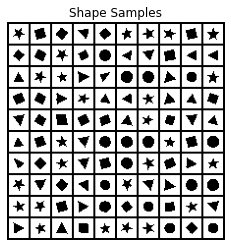

In [82]:
visualize_q1_data()

In [83]:
base_dist = Uniform(torch.tensor([0.]), torch.tensor([1.]))
af = AutoregressiveFlow(base_dist, 1, 5, n_layers=3)

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [87]:
def q1(train_data, test_data):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    H = W = 20
    Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
    """
      
    test_data = 0.5 * (test_data + np.random.uniform(size=test_data.shape))
    
    base_dist = Uniform(torch.tensor([0.]), torch.tensor([1.]))
    af = AutoregressiveFlow(base_dist, 1, 5, n_layers=3)
    optim = Adam(af.parameters(), lr=1e-3)
    
    train_dl = DataLoader(train_data.transpose(0, 3, 1, 2), batch_size=64, shuffle=True)
    test_dl = DataLoader(test_data.transpose(0, 3, 1, 2), batch_size=64)
    
    train_losses, test_losses = train(af, optim, train_dl, test_dl, 15)
    
    samples = sample(af, train_data.shape[1:])
    
    return train_losses, test_losses, samples

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/164 [00:00<?, ?it/s]

Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Training:   0%|          | 0/164 [00:00<?, ?it/s]

Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Training:   0%|          | 0/164 [00:00<?, ?it/s]

Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Training:   0%|          | 0/164 [00:00<?, ?it/s]

Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Training:   0%|          | 0/164 [00:00<?, ?it/s]

Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Training:   0%|          | 0/164 [00:00<?, ?it/s]

Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Training:   0%|          | 0/164 [00:00<?, ?it/s]

Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Training:   0%|          | 0/164 [00:00<?, ?it/s]

Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Training:   0%|          | 0/164 [00:00<?, ?it/s]

Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Training:   0%|          | 0/164 [00:00<?, ?it/s]

Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Training:   0%|          | 0/164 [00:00<?, ?it/s]

Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Training:   0%|          | 0/164 [00:00<?, ?it/s]

Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Training:   0%|          | 0/164 [00:00<?, ?it/s]

Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Training:   0%|          | 0/164 [00:00<?, ?it/s]

Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Training:   0%|          | 0/164 [00:00<?, ?it/s]

Testing:   0%|          | 0/71 [00:00<?, ?it/s]

Sampling:   0%|          | 0/400 [00:00<?, ?it/s]

Final Test Loss: 0.1251


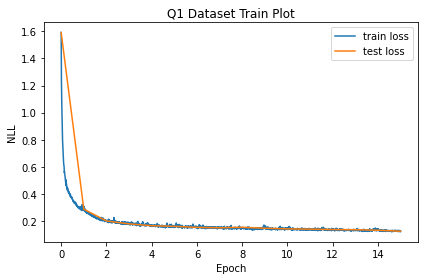

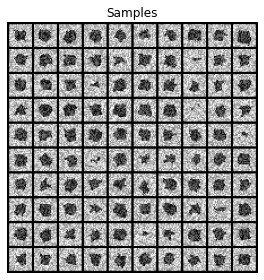

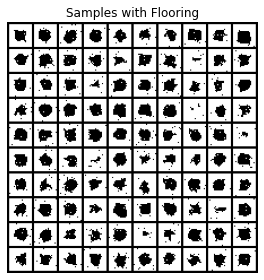

In [88]:
q1_save_results(q1)